<a href="https://colab.research.google.com/github/harsh2k1/LGMVIP-DataScience/blob/main/Stock_Price_Prediction_using_Numerical_and_Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name: Harshpreet Singh
# Task-1 GRIP-October 2021
# Stock Market prediction using numerical and textual analysis 
# Level: Advanced

# Importing libraries

In [ ]:
#!pip install yfinance

In [ ]:
#!pip install pmdarima

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm
#from pmdarima import auto_arima

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Getting data

## 1. Latest bsesn data

In [ ]:
bse_data = yf.download('^BSESN', start='2001-01-01', end='2021-10-05')

[*********************100%***********************]  1 of 1 completed


In [ ]:
bse_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0
...,...,...,...,...,...,...
2021-09-28,60285.890625,60288.441406,59045.531250,59667.601562,59667.601562,21100
2021-09-29,59296.539062,59678.660156,59111.410156,59413.269531,59413.269531,16100
2021-09-30,59549.570312,59557.238281,59019.281250,59126.359375,59126.359375,8900


In [ ]:
bse_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
bse_data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

## 2. News headlines data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/My Drive/india-news-headlines.csv'
news_df = pd.read_csv(path)
news_df.tail()

,publish_date,headline_category,headline_text
3424062,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,removed,Govt extends deadline for use of FASTag till F...
3424066,20201231,entertainment.bengali.movies.news,Celebs plan to party safely and responsibly on...


In [ ]:
news_df.isnull().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

# Feature extraction and Data Cleaning

## Extracting Closing Price from bse data

In [ ]:
stock_df = pd.DataFrame(bse_data['Close'] , index = bse_data.index , columns = ['Close'])
stock_df.head()

,Close
Date,
2001-01-02,4018.879883
2001-01-03,4060.020020
2001-01-04,4115.370117
2001-01-05,4183.729980
2001-01-08,4120.430176


## Converting dates to datetime datatype

In [ ]:
news_df['publish_date'] = pd.to_datetime(news_df['publish_date'],format= '%Y%m%d')
news_df[:5]

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic


In [ ]:
news_df.dtypes

publish_date         datetime64[ns]
headline_category            object
headline_text                object
dtype: object

In [ ]:
# Setting index as publish date
news_df.drop(['headline_category'], axis = 1, inplace = True)
news_df.set_index('publish_date', inplace = True)
news_df.head()

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-02,Fissures in Hurriyat over Pak visit
2001-01-02,America's unwanted heading for India?
2001-01-02,For bigwigs; it is destination Goa
2001-01-02,Extra buses to clear tourist traffic


In [ ]:
news_df.index = news_df.index.rename('Date')

In [ ]:
# Grouping the headlines for each day
news_df['date'] = news_df.index
news_df['headline_text'] = news_df.groupby(['date']).transform(lambda x : ' '.join(x)) 
news_df = news_df.drop_duplicates() 
# news_df.reset_index(inplace = True, drop = True)
news_df.set_index('date', inplace = True)
news_df[:11]

,headline_text
date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,Powerless north India gropes in the dark Think...
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
2001-01-07,Muslim body rules out talks on Ayodhya Bajrang...
2001-01-08,Sangh Parivar; Babri panel up the ante Frontru...
2001-01-09,Financier Bharat Shah held for alleged links w...
2001-01-10,Fend for yourselves; Pande tells doctors Burea...


In [ ]:
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Cleaning text
stopwords_english =  stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_data(text):
    text_clean = []
    text_tokens = word_tokenize(text)
    #text_tokens = tokenizer.tokenize(text)    
    for word in text_tokens:
        if (word not in stopwords_english and # remove stopwords
                word not in string.punctuation): # remove punctuation
            #tweets_clean.append(word)
            stem_word = lemmatizer.lemmatize(word) # stemming word
            text_clean.append(stem_word)
    
    list_to_str = ' '.join([str(ele) for ele in text_clean])
    return list_to_str.lower()

In [ ]:
news_df['headline_text'] = news_df['headline_text'].apply(clean_data)
news_df[:11]

,headline_text
date,
2001-01-02,status quo disturbed ayodhya say vajpayee fiss...
2001-01-03,powerless north india grope dark think laxman ...
2001-01-04,the string pulled stephen hawking india vajpay...
2001-01-05,light combat craft take india club class hawki...
2001-01-06,light combat craft take india club class hawki...
2001-01-07,muslim body rule talk ayodhya bajrang dal blow...
2001-01-08,sangh parivar babri panel ante frontrunner key...
2001-01-09,financier bharat shah held alleged link chotta...
2001-01-10,fend pande tell doctor bureaucracy undermining...


# Data Visualization of BSE data

## 1. Line plot of Closing price

Text(0.5, 1.0, 'Line plot for Closed price')

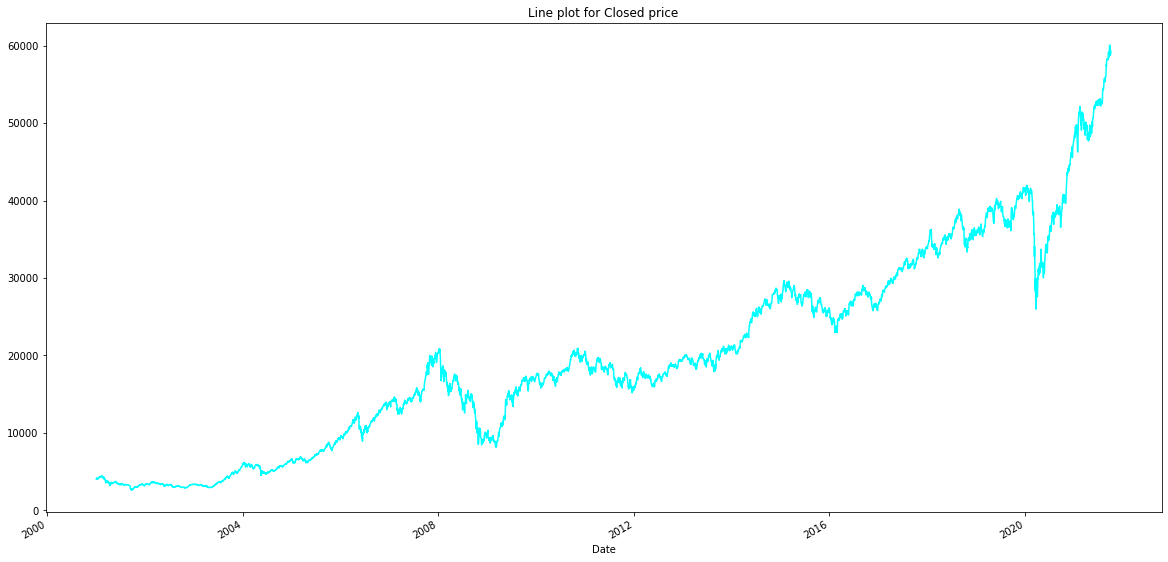

In [ ]:
stock_df['Close'].plot(figsize = (20,10), color = 'cyan')
plt.title('Line plot for Closed price')

## 2. Distribution of Closing Price

Text(0.5, 1.0, 'Distribution plot for Closing price')

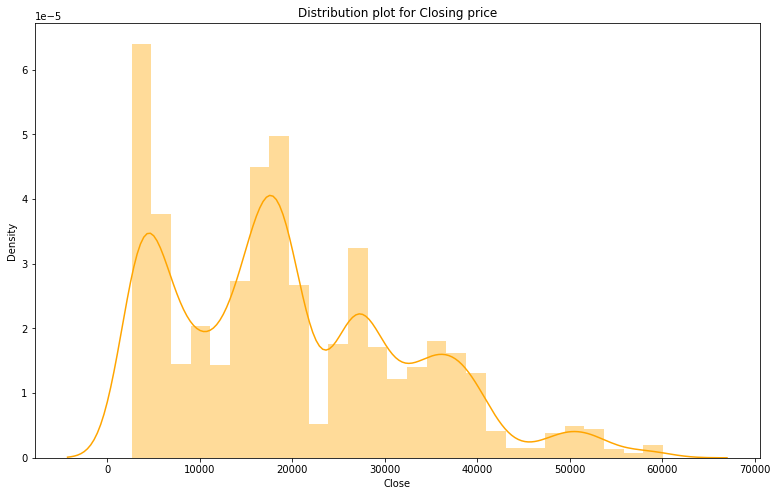

In [ ]:
plt.figure(figsize = (13,8))
sns.distplot(stock_df['Close'], color = 'orange')
plt.title('Distribution plot for Closing price')

## 3. Lag plot

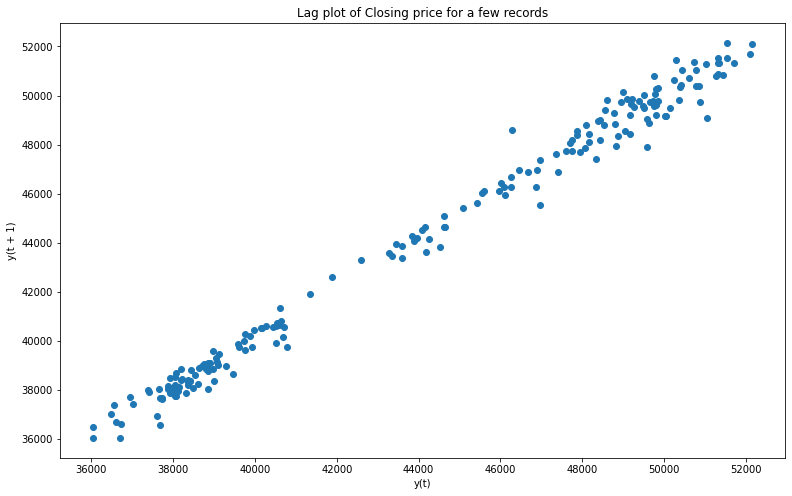

In [ ]:
plt.figure(figsize=(13,8))
lag_plot(stock_df.iloc[4800:5000])
ax = plt.axes()
plt.title('Lag plot of Closing price for a few records')
plt.show()

## 4. ACF and PACF plots

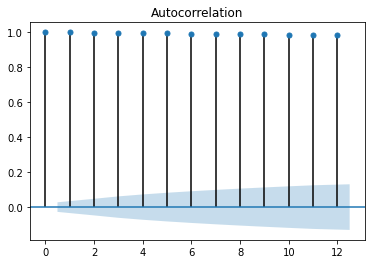

In [ ]:
tsa_plots.plot_acf(stock_df.Close,lags=12)
plt.show()

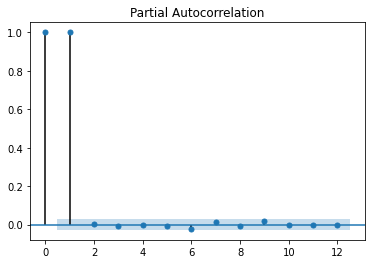

In [ ]:
tsa_plots.plot_pacf(stock_df.Close,lags=12)
plt.show()

## 5. Decomposition of Closing price

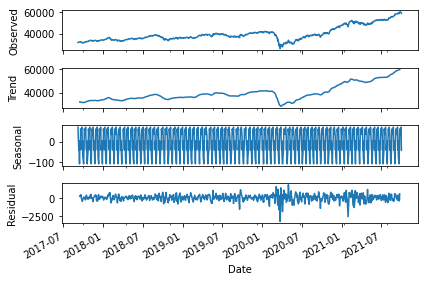

In [ ]:
decompose_ts = seasonal_decompose(stock_df.iloc[-1000:-1],freq = 12)
decompose_ts.plot()
plt.show()

#### Multiplicative trend and Additive Seasonality can be observed

## 6. Plotting Moving Average

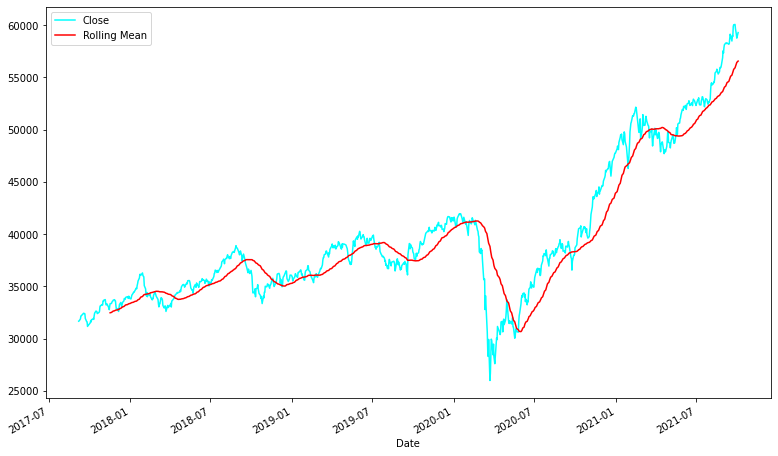

In [ ]:
close = stock_df['Close'][-1000:]
ma = close.rolling(window = 50).mean()

plt.figure(figsize=(13,8))
close.plot(color = 'cyan', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
plt.legend()

## 7. Returns

Text(0.5, 1.0, 'Returns')

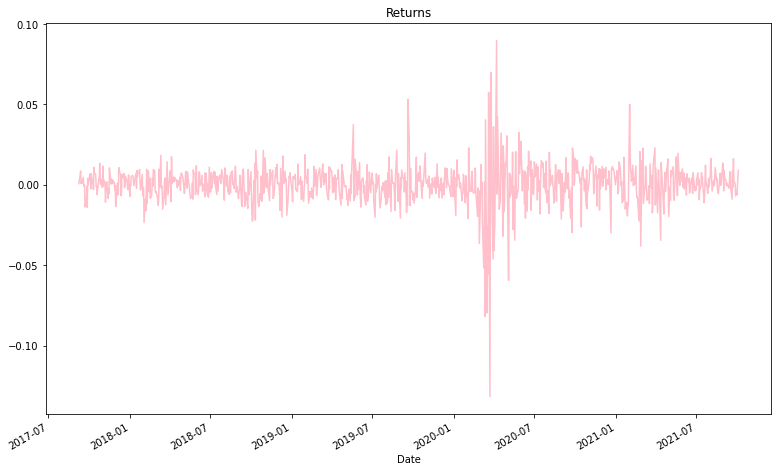

In [ ]:
returns = close / close.shift(1) - 1

plt.figure(figsize = (13,8))
returns.plot(label='Return', color = 'pink')
plt.title("Returns")

In [ ]:
close = pd.DataFrame(stock_df['Close'], index = stock_df.index , columns = ['Close'])
returns = close / close.shift(1) - 1
close['returns'] = returns
temp = close.sort_values(['returns'], ascending=[False])
plt.figure(figsize = (20,8))
sns.barplot(x = temp[:11].index , y = temp[:11].returns)
plt.title('Top 10 days with highest returns')

#### Highest returns on 18-05-2009

# Data Pre-Processing

## 1. BSE data

### Data Scaling

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
stock_df['Close'] = scaler.fit_transform(np.array(stock_df['Close']).reshape(-1,1))
stock_df[:6]

,Close
Date,
2001-01-02,0.024684
2001-01-03,0.025399
2001-01-04,0.026362
2001-01-05,0.027552
2001-01-08,0.026450
2001-01-09,0.026535


## 2. News headlines data

### Sentiment analysis

In [ ]:
nltk.download('vader_lexicon')
from textblob import TextBlob

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
# Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:
# Sentiment analysis
news_df['Subjectivity'] = news_df['headline_text'].apply(getSubjectivity)
news_df['Polarity'] = news_df['headline_text'].apply(getPolarity)
news_df['Compound'] = [sia.polarity_scores(v)['compound'] for v in news_df['headline_text']]
news_df['Negative'] = [sia.polarity_scores(v)['neg'] for v in news_df['headline_text']]
news_df['Neutral'] = [sia.polarity_scores(v)['neu'] for v in news_df['headline_text']]
news_df['Positive'] = [sia.polarity_scores(v)['pos'] for v in news_df['headline_text']]
news_df[:11]

,headline_text,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
date,,,,,,,
2001-01-02,status quo disturbed ayodhya say vajpayee fiss...,0.273264,0.136806,-0.9486,0.147,0.747,0.106
2001-01-03,powerless north india grope dark think laxman ...,0.458333,0.062500,0.2023,0.140,0.717,0.143
2001-01-04,the string pulled stephen hawking india vajpay...,0.449244,0.071931,0.5106,0.124,0.752,0.123
2001-01-05,light combat craft take india club class hawki...,0.477807,0.266578,0.9740,0.149,0.667,0.183
2001-01-06,light combat craft take india club class hawki...,0.439394,0.248485,-0.4215,0.166,0.678,0.156
2001-01-07,muslim body rule talk ayodhya bajrang dal blow...,0.375748,-0.058139,-0.9944,0.161,0.806,0.033
2001-01-08,sangh parivar babri panel ante frontrunner key...,0.411492,-0.038444,-0.9666,0.139,0.775,0.086
2001-01-09,financier bharat shah held alleged link chotta...,0.513554,-0.063411,-0.9947,0.167,0.768,0.064
2001-01-10,fend pande tell doctor bureaucracy undermining...,0.000000,0.000000,-0.7845,0.345,0.655,0.000


# 3. Merging BSE and News headlines data

In [ ]:
news_df.insert(loc = 0, column = 'key', value = news_df.index)
stock_df.insert(loc = 0, column = 'key', value = stock_df.index)

In [ ]:
df = pd.merge(stock_df, news_df, how='inner', on='key')
df.head(10)

,key,Close,headline_text,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,0.024684,status quo disturbed ayodhya say vajpayee fiss...,0.273264,0.136806,-0.9486,0.147,0.747,0.106
1,2001-01-03,0.025399,powerless north india grope dark think laxman ...,0.458333,0.062500,0.2023,0.140,0.717,0.143
2,2001-01-04,0.026362,the string pulled stephen hawking india vajpay...,0.449244,0.071931,0.5106,0.124,0.752,0.123
3,2001-01-05,0.027552,light combat craft take india club class hawki...,0.477807,0.266578,0.9740,0.149,0.667,0.183
4,2001-01-08,0.026450,sangh parivar babri panel ante frontrunner key...,0.411492,-0.038444,-0.9666,0.139,0.775,0.086
5,2001-01-09,0.026535,financier bharat shah held alleged link chotta...,0.513554,-0.063411,-0.9947,0.167,0.768,0.064
6,2001-01-10,0.025184,fend pande tell doctor bureaucracy undermining...,0.000000,0.000000,-0.7845,0.345,0.655,0.000
7,2001-01-23,0.029517,sonia take hindutva brigade congress hope soar...,0.268245,0.070265,0.9228,0.060,0.828,0.113
8,2001-01-24,0.030034,govt extends j k ceasefire month peace hinge h...,0.244286,0.080952,0.2263,0.138,0.716,0.146
9,2001-01-25,0.030100,big bath pass without hitch security bandobast...,0.453185,0.029029,-0.9887,0.178,0.726,0.096


In [ ]:
#df.to_csv('MergedData.csv')

In [ ]:
df['key'] = pd.to_datetime(df['key'])
df.set_index('key',inplace=True)

## Feature selection

In [ ]:
df.head()

,Close,headline_text,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
key,,,,,,,,
2001-01-02,0.024684,status quo disturbed ayodhya say vajpayee fiss...,0.273264,0.136806,-0.9486,0.147,0.747,0.106
2001-01-03,0.025399,powerless north india grope dark think laxman ...,0.458333,0.062500,0.2023,0.140,0.717,0.143
2001-01-04,0.026362,the string pulled stephen hawking india vajpay...,0.449244,0.071931,0.5106,0.124,0.752,0.123
2001-01-05,0.027552,light combat craft take india club class hawki...,0.477807,0.266578,0.9740,0.149,0.667,0.183
2001-01-08,0.026450,sangh parivar babri panel ante frontrunner key...,0.411492,-0.038444,-0.9666,0.139,0.775,0.086


In [ ]:
data = df.copy()

In [ ]:
df = df.drop(['headline_text'],axis = 1)
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
key,,,,,,,
2001-01-02,0.024684,0.273264,0.136806,-0.9486,0.147,0.747,0.106
2001-01-03,0.025399,0.458333,0.062500,0.2023,0.140,0.717,0.143
2001-01-04,0.026362,0.449244,0.071931,0.5106,0.124,0.752,0.123
2001-01-05,0.027552,0.477807,0.266578,0.9740,0.149,0.667,0.183
2001-01-08,0.026450,0.411492,-0.038444,-0.9666,0.139,0.775,0.086


# Modelling

## 1. Without using sentiments
refer to <a href = "https://github.com/harsh2k1/-Stock-Market-prediction-using-numerical-and-textual-analysis/blob/main/StockPredictionw_oSentiment.ipynb">this notebook</a>

## 2. Using Sentiment as well as numerical analysis

### a. Splitting data

In [ ]:
df1 = df.copy()
time_step = 100
for i in range(1, time_step+1):
  df1[f'{i}'] = df['Close'].shift(i)
df1.dropna(inplace=True)

In [ ]:
df1.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-07-09,0.012017,0.476989,0.025597,-0.5090,0.139,0.713,0.147,0.012277,0.012483,0.012390,0.014369,0.014904,0.014001,0.014119,0.014044,0.012501,0.013599,0.014014,0.014022,0.014912,0.014961,0.015628,0.016659,0.018475,0.019868,0.019486,0.018437,0.018102,0.018353,0.018610,0.017258,0.016995,0.016855,0.016696,0.016844,0.017162,0.017054,0.016436,0.015910,0.015560,...,0.019932,0.021221,0.019571,0.016363,0.022301,0.024322,0.026011,0.029081,0.028653,0.025567,0.026316,0.026481,0.028923,0.029613,0.030456,0.030102,0.031975,0.030673,0.030672,0.031424,0.031268,0.030987,0.029800,0.030884,0.030801,0.030484,0.029333,0.030039,0.030828,0.028436,0.030100,0.030034,0.029517,0.025184,0.026535,0.026450,0.027552,0.026362,0.025399,0.024684
2001-07-10,0.012668,0.409042,0.083492,-0.9814,0.174,0.716,0.110,0.012017,0.012277,0.012483,0.012390,0.014369,0.014904,0.014001,0.014119,0.014044,0.012501,0.013599,0.014014,0.014022,0.014912,0.014961,0.015628,0.016659,0.018475,0.019868,0.019486,0.018437,0.018102,0.018353,0.018610,0.017258,0.016995,0.016855,0.016696,0.016844,0.017162,0.017054,0.016436,0.015910,...,0.019527,0.019932,0.021221,0.019571,0.016363,0.022301,0.024322,0.026011,0.029081,0.028653,0.025567,0.026316,0.026481,0.028923,0.029613,0.030456,0.030102,0.031975,0.030673,0.030672,0.031424,0.031268,0.030987,0.029800,0.030884,0.030801,0.030484,0.029333,0.030039,0.030828,0.028436,0.030100,0.030034,0.029517,0.025184,0.026535,0.026450,0.027552,0.026362,0.025399
2001-07-11,0.013502,0.434152,0.035212,-0.9963,0.176,0.756,0.069,0.012668,0.012017,0.012277,0.012483,0.012390,0.014369,0.014904,0.014001,0.014119,0.014044,0.012501,0.013599,0.014014,0.014022,0.014912,0.014961,0.015628,0.016659,0.018475,0.019868,0.019486,0.018437,0.018102,0.018353,0.018610,0.017258,0.016995,0.016855,0.016696,0.016844,0.017162,0.017054,0.016436,...,0.018656,0.019527,0.019932,0.021221,0.019571,0.016363,0.022301,0.024322,0.026011,0.029081,0.028653,0.025567,0.026316,0.026481,0.028923,0.029613,0.030456,0.030102,0.031975,0.030673,0.030672,0.031424,0.031268,0.030987,0.029800,0.030884,0.030801,0.030484,0.029333,0.030039,0.030828,0.028436,0.030100,0.030034,0.029517,0.025184,0.026535,0.026450,0.027552,0.026362
2001-07-12,0.014834,0.437500,0.086198,-0.9409,0.148,0.771,0.081,0.013502,0.012668,0.012017,0.012277,0.012483,0.012390,0.014369,0.014904,0.014001,0.014119,0.014044,0.012501,0.013599,0.014014,0.014022,0.014912,0.014961,0.015628,0.016659,0.018475,0.019868,0.019486,0.018437,0.018102,0.018353,0.018610,0.017258,0.016995,0.016855,0.016696,0.016844,0.017162,0.017054,...,0.020720,0.018656,0.019527,0.019932,0.021221,0.019571,0.016363,0.022301,0.024322,0.026011,0.029081,0.028653,0.025567,0.026316,0.026481,0.028923,0.029613,0.030456,0.030102,0.031975,0.030673,0.030672,0.031424,0.031268,0.030987,0.029800,0.030884,0.030801,0.030484,0.029333,0.030039,0.030828,0.028436,0.030100,0.030034,0.029517,0.025184,0.026535,0.026450,0.027552
2001-07-13,0.014856,0.448691,0.072843,-0.9930,0.152,0.734,0.113,0.014834,0.013502,0.012668,0.012017,0.012277,0.012483,0.012390,0.014369,0.014904,0.014001,0.014119,0.014044,0.012501,0.013599,0.014014,0.014022,0.014912,0.014961,0.015628,0.016659,0.018475,0.019868,0.019486,0.018437,0.018102,0.018353,0.018610,0.017258,0.016995,0.016855,0.016696,0.016844,0.017162,...,0.019379,0.020720,0.018656,0.019527,0.019932,0.021221,0.019571,0.016363,0.022301,0.024322,0.026011,0.029081,0.028653,0.025567,0.026316,0.026481,0.028923,0.029613,0.030456,0.030102,0.031975,0.030673,0.030672,0.031424,0.031268,0.030987,0.029800,0.030884,0.030801,0.030484,0.029333,0.030039,0.030828,0.028436,0.030100,0.030034,0.029517,0.025184,0.026535,0.026450


In [ ]:
# Into train and test
training_size = int(len(df1) * 0.65)      # 65% of length of data
test_size = len(df1) - training_size      # 35% of length of data
train_data, test_data = df1.iloc[0:training_size, :], df1.iloc[training_size:len(df1), :]

In [ ]:
len(df1),training_size , test_size 

(4793, 3115, 1678)

In [ ]:
# Into dependent and independent features
X_train = train_data.iloc[:,1:]
X_test = test_data.iloc[:,1:]
y_train = train_data.iloc[:,0]
y_test = test_data.iloc[:,0]

In [ ]:
X_train.shape, y_train.shape, X_test.shape , y_test.shape

((3115, 106), (3115,), (1678, 106), (1678,))

### b. Modelling using Dense model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM , Dropout
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
model = Sequential()
model.add(Dense(100,input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(50,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               10700     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 25,901
Trainable params: 25,901
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=20,verbose=1)

Epoch 1/50
156/156 [==============================] - 2s 8ms/step - loss: 0.0031 - accuracy: 3.2103e-04 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 2/50
156/156 [==============================] - 1s 5ms/step - loss: 5.9057e-04 - accuracy: 3.2103e-04 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 3/50
156/156 [==============================] - 1s 5ms/step - loss: 3.8423e-04 - accuracy: 3.2103e-04 - val_loss: 0.0154 - val_accuracy: 0.0000e+00
Epoch 4/50
156/156 [==============================] - 1s 6ms/step - loss: 3.4352e-04 - accuracy: 3.2103e-04 - val_loss: 0.0088 - val_accuracy: 0.0000e+00
Epoch 5/50
156/156 [==============================] - 1s 6ms/step - loss: 2.7245e-04 - accuracy: 3.2103e-04 - val_loss: 0.0063 - val_accuracy: 0.0000e+00
Epoch 6/50
156/156 [==============================] - 1s 5ms/step - loss: 2.7497e-04 - accuracy: 3.2103e-04 - val_loss: 0.0092 - val_accuracy: 0.0000e+00
Epoch 7/50
156/156 [==============================] - 1s 5ms/step - loss: 2.5593

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.round(np.sqrt(mean_squared_error(y_test,test_predict)),4)
print('RMSE Value: ',rmse)

RMSE Value:  0.0613


In [ ]:
# Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
y_train = scaler.inverse_transform(np.array(y_train).reshape(-1,1))
y_test = scaler.inverse_transform(np.array(y_test).reshape(-1,1))

### c. Performance evaluation

#### Training vs Testing loss

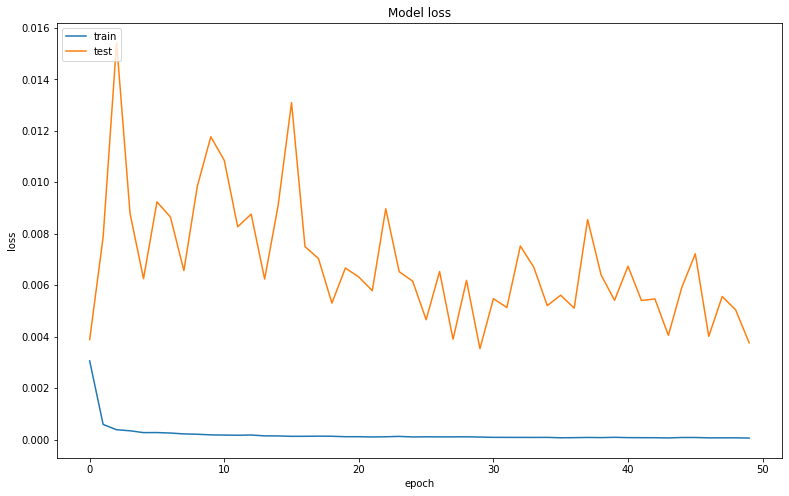

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Calculating RMSE Score

In [ ]:
# Calculating RMSE performance metrics
from sklearn.metrics import mean_squared_error
rmse = np.round(np.sqrt(mean_squared_error(y_test,test_predict)),2)
print('RMSE Value: ',rmse)

RMSE Value:  2922.84


In [ ]:
eval_df = pd.DataFrame(y_test, columns = ['Close'])
eval_df['Predicted Close'] = test_predict

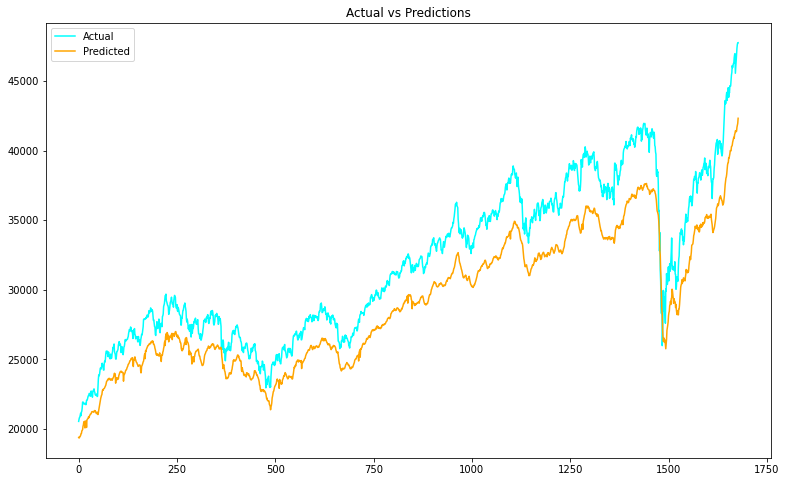

In [ ]:
eval_df['Close'].plot(figsize=(13,8), label = 'Actual', color = 'cyan')
eval_df['Predicted Close'].plot(figsize=(13,8), label = 'Predicted', color = 'orange')
plt.title('Actual vs Predictions')
plt.legend()

# Conclusion
1. The study was divided into 2 parts:<br>
a. Stock Price prediction without using sentiment analysis.<br>
b. Stock Price prediction using sentiment as well as numerical analysis.
2. For part a. LSTM model was used because it has the ability to remember long past time-series patterns. For part b. Dense layers were used in Sequential model because the data is no longer a time-series but time-series + sentimental values data. 
3. The results were somewhat accurate. The LSTM model provided more accurate results.
3. Taking into account the sentiment values, the corresponding model offered more reliable results as compared to LSTM model because it was depending on real time sentiments which plays a huge impact in the stock price in real world.
4. Although the model provided accurate results, it cannot be used in real time stock price forecasting because better accuracy is required.
5. future improvements:  can be achieved through relevant news headlines (headlines based on stocks only) and using hyperparameter tuning of the neural networks.